# Attempt to forecast the price of MSFT by analyzing the prices of multiple stocks, including MSFT, over several consecutive days leading up to the target day.
#### N.B. Different setup from HW1

In [1]:
from torch.utils.data import DataLoader,Dataset

class StockDataset(Dataset):
    def __init__(self,X,Y,days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days # days ahead for prediction

    def __len__(self):
        return (len(self.Y)-self.days)

    def __getitem__(self,index):
        x=self.X[:,index:index+self.days]
        y=self.Y[index+self.days]
        return x,y



In [2]:
# !pip install pandas
# !pip install yfinance
import numpy as np
from numpy import exp, sum, log, log10
import yfinance as yf
import pandas as pd

def get_price(tick,start='2020-01-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2020-01-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df

feature_stocks=['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock='msft'

# getting data
start_date='2020-01-01'

allX=get_prices(feature_stocks,start=start_date)
ally=get_prices([predict_stock],start=start_date)

In [3]:
import torch.utils.data as data
import torch

stockData = StockDataset(allX.to_numpy().transpose().astype(np.float32),ally.to_numpy().astype(np.float32),days=5)
train_set_size = int(len(stockData)*0.7)
valid_set_size = int(len(stockData)*0.2)
test_set_size = len(stockData)-train_set_size-valid_set_size

train_set, valid_set, test_set = data.random_split(stockData,[train_set_size,valid_set_size,test_set_size],\
                                              generator=torch.Generator().manual_seed(42))

batch_size = train_set_size # use entire dataset as batch
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)  # input:(20,5), label:1
valid_dataloader = DataLoader(valid_set,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=False)

# 1. Build a simple MLP to forecast MSFT price using PyTorch Lightning.

#### You have total freedom of your MLP. But your MLP should take the last five day ($5 \times 20=100$) prices as input and you have to add dropout into your network.

## 1a. Create a subclass of pytorch_lightning.LightningModule. It should include \_\_init\_\_, training_step, validation_step, configure_optimizers in the class. (6 points)

## 1b. Create a subclass of pytorch_lightning.LightningDataModule. It should include \_\_init\_\_, train_dataloader, and val_dataloader in the class. (4 points)

## 1c. Complete the rest of the code and train the model with 70% of the data. You should set aside 15% of the data each for validation and testing.  Show the training and validation MSE (5 points)

# 2. Construct a 1-D CNN to forecast MSFT stock price. You are free to use any design, but your network must consist of at least one convolutional layer and one dropout layer. You can also extend the duration leading up to the target day by modifying the "days" argument in the StockDataset. But "days" should not be larger than 32. (10 points)


# 3. Please try to enhance the performance of the previously created MLP or CNN by applying hyperparameter tuning. You can use tools such as W&B hyperparameter sweep, SMAP, Optuna, or similar packages to achieve this. You need to optimize at least two parameters, with the dropout rate being one of them. (5 points)












In [5]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-mq74cnz7
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-mq74cnz7
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit ca13f77eab5d8b85ee84eb9fd7484c324ba198b1
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 KB 11.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 KB 33.4 MB/s eta 0:00:00
  Created wheel for lightning: filename=lightning-2.5.1rc2-py3-none-any.whl size=819099 sha256=ef1ea761772ab6b1b71a17ee80b580850aa5c3c5e29ddd5436e2c46fa17b5e50
  Stored in directory: /tmp/pip-ephem-wheel-ca

In [6]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import copy
import yfinance as yf
import pandas as pd
import numpy as np

# ------------------------------
# Dataset and Data Preparation
# ------------------------------
class StockDataset(Dataset):
    def __init__(self, X, Y, days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days  # days ahead for prediction

    def __len__(self):
        return len(self.Y) - self.days

    def __getitem__(self, index):
        x = self.X[:, index:index + self.days]  # shape: (num_stocks, days)
        y = self.Y[index + self.days]
        return x, y

def get_price(tick, start='2020-01-01', end=None):
    return yf.Ticker(tick).history(start=start, end=end)['Close']

def get_prices(tickers, start='2020-01-01', end=None):
    df = pd.DataFrame()
    for s in tickers:
        df[s] = get_price(s, start, end)
    return df

# Define tickers
feature_stocks = ['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock = 'msft'
start_date = '2020-01-01'

allX = get_prices(feature_stocks, start=start_date)
ally = get_prices([predict_stock], start=start_date)

# Create dataset: note that we transpose allX so that each column is a time step.
stockData = StockDataset(allX.to_numpy().transpose().astype(np.float32),
                         ally.to_numpy().astype(np.float32),
                         days=5)

# Split dataset: 70% train, 15% valid, 15% test.
dataset_size = len(stockData)
train_size = int(dataset_size * 0.70)
valid_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - valid_size

train_set, valid_set, test_set = random_split(stockData, [train_size, valid_size, test_size],
                                                generator=torch.Generator().manual_seed(42))

batch_size = 64  # you can adjust the batch size as needed




/home/ikem/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# ------------------------------
# Lightning Data Module
# ------------------------------
class StockDataModule(pl.LightningDataModule):
    def __init__(self, train_set, valid_set, test_set, batch_size):
        super().__init__()
        self.train_set = train_set
        self.valid_set = valid_set
        self.test_set = test_set
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False)

data_module = StockDataModule(train_set, valid_set, test_set, batch_size)

# ------------------------------
# Lightning Module: MLP Forecasting Model
# ------------------------------
class MSFTForecastingMLP(pl.LightningModule):
    def __init__(self):
        super(MSFTForecastingMLP, self).__init__()
        # The input is 5 days of data for 20 stocks: 5*20 = 100 features.
        self.model = nn.Sequential(
            nn.Flatten(),              # Flatten input (20, 5) -> (100,)
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1)           # Output single forecast value
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# ------------------------------
# Callback to Record Loss History
# ------------------------------
class LossHistory(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_validation_epoch_end(self, trainer, pl_module):
        # trainer.callback_metrics is a dictionary that stores the logged metrics.
        # Ensure the keys match those we logged.
        train_loss = trainer.callback_metrics.get("train_loss")
        val_loss = trainer.callback_metrics.get("val_loss")
        if train_loss is not None and val_loss is not None:
            self.train_losses.append(train_loss.item())
            self.val_losses.append(val_loss.item())


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ikem/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performan

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ikem/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ikem/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/ikem/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 15/15 [00:00<00:00, 18.19it/s, v_num=0, train_loss_step=2.25e+4]

/home/ikem/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 15/15 [00:00<00:00, 15.95it/s, v_num=0, train_loss_step=2.25e+4, val_loss=1.3e+4, train_loss_epoch=4.96e+4]

/home/ikem/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 239.54it/s, v_num=0, train_loss_step=1.37e+4, val_loss=8.34e+3, train_loss_epoch=1.57e+4]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 224.68it/s, v_num=0, train_loss_step=1.37e+4, val_loss=8.34e+3, train_loss_epoch=1.57e+4]


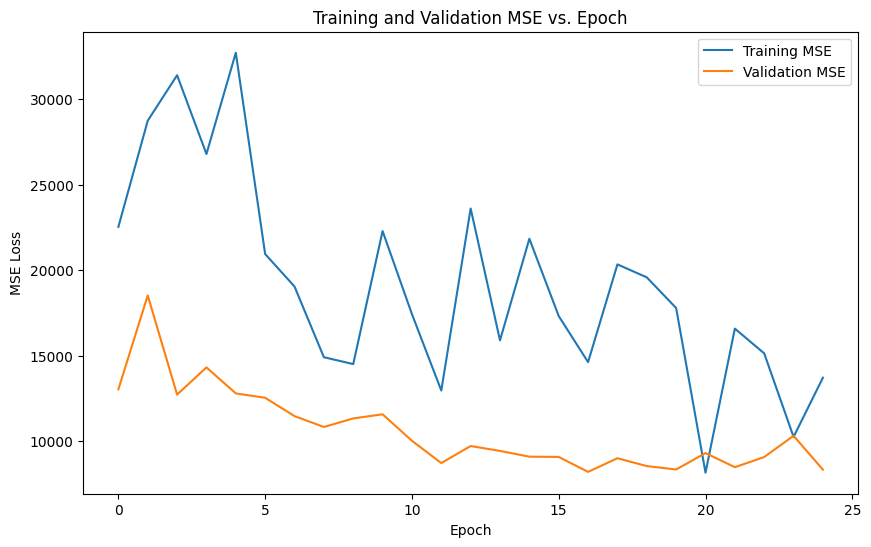

In [8]:

# Instantiate model and callback
model = MSFTForecastingMLP()
loss_history = LossHistory()

# ------------------------------
# Training
# ------------------------------
# Set up PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=25, callbacks=[loss_history], log_every_n_steps=1)

# Train the model using the data module (which provides 70% training and 15% validation data)
trainer.fit(model, datamodule=data_module)

# ------------------------------
# Plotting Training and Validation MSE vs Epoch
# ------------------------------
plt.figure(figsize=(10,6))
plt.plot(loss_history.train_losses, label='Training MSE')
plt.plot(loss_history.val_losses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE vs. Epoch')
plt.legend()
plt.show()

Part 2: Convolution Neural Networkds

In [12]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim

class MSFTForecastingCNN(pl.LightningModule):
    def __init__(self, num_features, days):
        """
        Args:
            num_features: Number of feature stocks (channels).
            days: Number of past days used (sequence length), should not exceed 32.
        """
        super(MSFTForecastingCNN, self).__init__()
        # A 1-D convolutional layer:
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # Dropout layer with 50% dropout probability
        self.dropout = nn.Dropout(0.5)
        # After the conv layer, the feature map has shape (batch, 32, days).
        # Flatten to a vector: 32 * days features.
        self.fc = nn.Linear(32 * days, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # x should have shape: (batch, num_features, days)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # Flatten the feature maps:
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch  # x: (batch, num_features, days), y: (batch,)
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        return loss


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [10]:
# Step 1: Split the dataset
dataset_size = len(stockData)
train_size = int(dataset_size * 0.70)
valid_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - valid_size

train_set, valid_set, test_set = random_split(stockData, [train_size, valid_size, test_size],
                                                generator=torch.Generator().manual_seed(42))

batch_size = 64  # Adjust as needed

# Option 1: Create DataLoaders directly
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 2.0 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 161    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 255.14it/s, v_num=8, train_loss_step=7.82e+3, val_loss=7.34e+3, train_loss_epoch=9.22e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 241.62it/s, v_num=8, train_loss_step=7.82e+3, val_loss=7.34e+3, train_loss_epoch=9.22e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 381.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      7355.9541015625      │
└───────────────────────────┴───────────────────────────┘

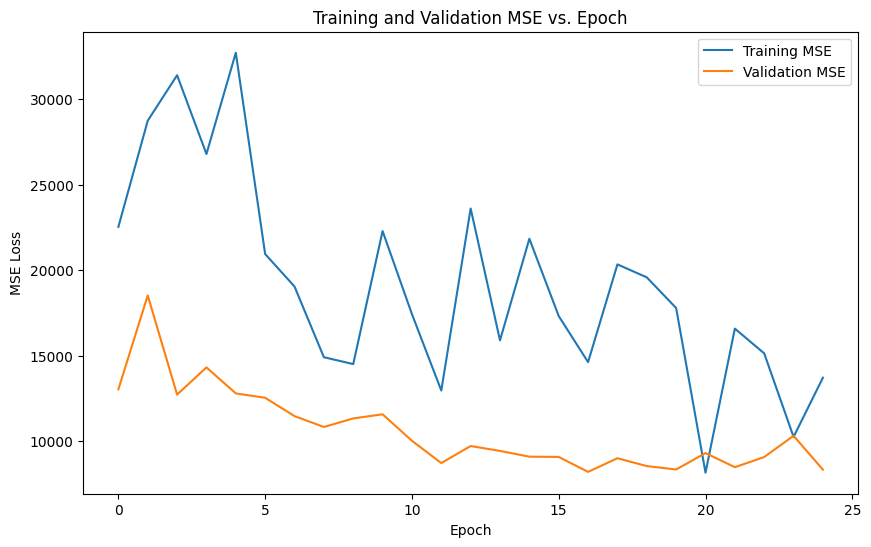

In [40]:


# Step 2: Instantiate your CNN model.
# The CNN expects input shape (batch, num_features, days).
# Here, num_features is the number of feature stocks and days is the number of past days used.
num_features = len(feature_stocks)  # e.g., 20 stocks
days = 5  # or any value <= 32
model = MSFTForecastingCNN(num_features=num_features, days=days)

# Step 3: Create a Trainer.
# (If using a newer version of PyTorch Lightning, you might not need progress_bar_refresh_rate)
trainer = pl.Trainer(max_epochs=25)

# Step 4: Train the model.
trainer.fit(model, datamodule=data_module)

# Step 5: Test the model.
trainer.test(model, datamodule=data_module)


# Step 6: Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history.train_losses, label='Training MSE')
plt.plot(loss_history.val_losses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE vs. Epoch')
plt.legend()
plt.show()

# Step 7: Save the model
torch.save(model.state_dict(), 'msft_forecasting_cnn.pth')  
# You can load it later using:
# model.load_state_dict(torch.load('msft_forecasting_cnn.pth'))
# model.eval()  # Set the model to evaluation mode
# Note: Ensure to use the same architecture when loading the state dict.
# You can also use PyTorch Lightning's built-in save and load methods.
trainer.save_checkpoint('msft_forecasting_cnn.ckpt')     

3. Optimization via Hyperparameter Tuning

In [43]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim

class MSFTForecastingCNN(pl.LightningModule):
    def __init__(self, num_features, days, dropout_rate=0.5, lr=1e-3, kernel_size=3, num_filters=32):
        """
        Args:
            num_features: Number of feature stocks (channels).
            days: Number of past days (sequence length, <= 32).
            dropout_rate: Dropout probability.
            lr: Learning rate.
            kernel_size: Kernel size for the 1-D convolution.
            num_filters: Number of filters (output channels) in the convolution.
        """
        super(MSFTForecastingCNN, self).__init__()
        self.save_hyperparameters()
        
        # Calculate padding so that output length equals input length.
        padding = (kernel_size - 1) // 2
        
        # Convolutional layer: input shape (batch, num_features, days)
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=num_filters, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        # After conv1, feature map shape: (batch, num_filters, days).
        # Flatten that and then predict a single value.
        self.fc = nn.Linear(num_filters * days, 1)
        self.criterion = nn.MSELoss()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # flatten the feature maps
        x = self.fc(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch  # x shape: (batch, num_features, days)
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        return loss
    
    # def configure_optimizers(self):
    #     optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
    #     return optimizer

    
#  Adding a method to configure optimizers for hyperparameter tuning

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


In [15]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 KB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 KB 31.1 MB/s eta 0:00:00


In [44]:
# 2. Define an Objective Function with Optuna

import optuna

num_features = len(feature_stocks)  # e.g., 20 stocks
days = 5  # or any value <= 32

def objective(trial):
   # Suggest hyperparameters:
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.8)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    # Only allow odd kernel sizes (e.g., 3, 5, or 7)
    kernel_size = trial.suggest_int("kernel_size", 3, 7, step=2)
    num_filters = trial.suggest_int("num_filters", 16, 64, step=16)
    
    # Instantiate the model with the suggested hyperparameters.
    model = MSFTForecastingCNN(num_features=num_features, days=days,
                               dropout_rate=dropout_rate, lr=lr,
                               kernel_size=kernel_size, num_filters=num_filters)
    
    
    # Create a Trainer; reduce max_epochs for quicker tuning.
    trainer = pl.Trainer(
        max_epochs=25,
        logger=False,
        enable_checkpointing=False,
    )
    
    # Train the model using your LightningDataModule (data_module must be defined)
    trainer.fit(model, datamodule=data_module)
    
    # Retrieve the validation loss from the trainer's logged metrics.
    # Ensure that "val_loss" is logged at the epoch level.
    val_loss = trainer.callback_metrics.get("val_loss")
    # In case it wasn't logged, fallback to a high value.
    if val_loss is None:
        return float('inf')
    return val_loss.item()


# 3. Run the Optuna Study
    


In [45]:
# Run the Optuna study

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-30 06:19:45,629] A new study created in memory with name: no-name-cdcc119f-29ec-4ef1-a52a-b9ade899e00c
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 9.0 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 321    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 262.28it/s, train_loss_step=8.24e+3, val_loss=7.28e+3, train_loss_epoch=9.93e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 258.62it/s, train_loss_step=8.24e+3, val_loss=7.28e+3, train_loss_epoch=9.93e+3]

[I 2025-03-30 06:19:47,556] Trial 0 finished with value: 7283.07080078125 and parameters: {'dropout_rate': 0.7843815073971292, 'lr': 0.0009945209022763142, 'kernel_size': 7, 'num_filters': 64}. Best is trial 0 with value: 7283.07080078125.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 4.8 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 241    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 260.19it/s, train_loss_step=7.25e+3, val_loss=7.68e+3, train_loss_epoch=8.9e+3] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 254.98it/s, train_loss_step=7.25e+3, val_loss=7.68e+3, train_loss_epoch=8.9e+3]

[I 2025-03-30 06:19:49,074] Trial 1 finished with value: 7684.48583984375 and parameters: {'dropout_rate': 0.5923376701043567, 'lr': 0.001257427129792001, 'kernel_size': 5, 'num_filters': 48}. Best is trial 0 with value: 7283.07080078125.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 3.2 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 161    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 255.88it/s, train_loss_step=1.18e+4, val_loss=7.48e+3, train_loss_epoch=1.05e+4]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 251.96it/s, train_loss_step=1.18e+4, val_loss=7.48e+3, train_loss_epoch=1.05e+4]


[I 2025-03-30 06:19:50,603] Trial 2 finished with value: 7479.01416015625 and parameters: {'dropout_rate': 0.6528675505553955, 'lr': 0.0017601313177046292, 'kernel_size': 5, 'num_filters': 32}. Best is trial 0 with value: 7283.07080078125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 4.8 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 241    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 251.77it/s, train_loss_step=1.01e+4, val_loss=8.53e+3, train_loss_epoch=9.17e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 248.38it/s, train_loss_step=1.01e+4, val_loss=8.53e+3, train_loss_epoch=9.17e+3]


[I 2025-03-30 06:19:52,118] Trial 3 finished with value: 8525.6181640625 and parameters: {'dropout_rate': 0.22302451429653503, 'lr': 0.00016301458349377604, 'kernel_size': 5, 'num_filters': 48}. Best is trial 0 with value: 7283.07080078125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 6.8 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 241    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 233.75it/s, train_loss_step=1.63e+4, val_loss=7.46e+3, train_loss_epoch=1.45e+4]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 230.38it/s, train_loss_step=1.63e+4, val_loss=7.46e+3, train_loss_epoch=1.45e+4]


[I 2025-03-30 06:19:53,652] Trial 4 finished with value: 7458.599609375 and parameters: {'dropout_rate': 0.7920571560262605, 'lr': 0.0060813964437827365, 'kernel_size': 7, 'num_filters': 48}. Best is trial 0 with value: 7283.07080078125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 2.9 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 241    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 257.76it/s, train_loss_step=8.85e+3, val_loss=8.04e+3, train_loss_epoch=8.71e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 254.36it/s, train_loss_step=8.85e+3, val_loss=8.04e+3, train_loss_epoch=8.71e+3]


[I 2025-03-30 06:19:55,198] Trial 5 finished with value: 8038.1953125 and parameters: {'dropout_rate': 0.21108851830175324, 'lr': 0.00028680083239455945, 'kernel_size': 3, 'num_filters': 48}. Best is trial 0 with value: 7283.07080078125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 976    | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 81     | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 258.31it/s, train_loss_step=1.25e+4, val_loss=7.39e+3, train_loss_epoch=1.05e+4]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 254.42it/s, train_loss_step=1.25e+4, val_loss=7.39e+3, train_loss_epoch=1.05e+4]


[I 2025-03-30 06:19:56,708] Trial 6 finished with value: 7388.1044921875 and parameters: {'dropout_rate': 0.5375145255622314, 'lr': 0.001526954907628738, 'kernel_size': 3, 'num_filters': 16}. Best is trial 0 with value: 7283.07080078125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 4.5 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 161    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 253.73it/s, train_loss_step=1.33e+4, val_loss=1.03e+4, train_loss_epoch=1.36e+4]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 250.21it/s, train_loss_step=1.33e+4, val_loss=1.03e+4, train_loss_epoch=1.36e+4]

[I 2025-03-30 06:19:58,256] Trial 7 finished with value: 10317.26953125 and parameters: {'dropout_rate': 0.587566744158553, 'lr': 0.0001405046027060973, 'kernel_size': 7, 'num_filters': 32}. Best is trial 0 with value: 7283.07080078125.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 1.6 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 81     | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 256.52it/s, train_loss_step=1.82e+4, val_loss=9.25e+3, train_loss_epoch=1.59e+4]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 252.74it/s, train_loss_step=1.82e+4, val_loss=9.25e+3, train_loss_epoch=1.59e+4]


[I 2025-03-30 06:19:59,762] Trial 8 finished with value: 9254.3095703125 and parameters: {'dropout_rate': 0.7577073146993912, 'lr': 0.0004293123871630369, 'kernel_size': 5, 'num_filters': 16}. Best is trial 0 with value: 7283.07080078125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 6.8 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 241    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 264.68it/s, train_loss_step=1.28e+4, val_loss=7.27e+3, train_loss_epoch=8.13e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 261.05it/s, train_loss_step=1.28e+4, val_loss=7.27e+3, train_loss_epoch=8.13e+3]


[I 2025-03-30 06:20:01,302] Trial 9 finished with value: 7268.658203125 and parameters: {'dropout_rate': 0.39877439229790623, 'lr': 0.0016261021367924117, 'kernel_size': 7, 'num_filters': 48}. Best is trial 9 with value: 7268.658203125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 9.0 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 321    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 241.81it/s, train_loss_step=6.61e+3, val_loss=7.5e+3, train_loss_epoch=8.61e+3] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 238.20it/s, train_loss_step=6.61e+3, val_loss=7.5e+3, train_loss_epoch=8.61e+3]


[I 2025-03-30 06:20:02,840] Trial 10 finished with value: 7498.748046875 and parameters: {'dropout_rate': 0.35244808000568667, 'lr': 0.006715908583559275, 'kernel_size': 7, 'num_filters': 64}. Best is trial 9 with value: 7268.658203125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 9.0 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 321    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 258.73it/s, train_loss_step=5.68e+3, val_loss=7.55e+3, train_loss_epoch=7.91e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 254.02it/s, train_loss_step=5.68e+3, val_loss=7.55e+3, train_loss_epoch=7.91e+3]


[I 2025-03-30 06:20:04,425] Trial 11 finished with value: 7554.8232421875 and parameters: {'dropout_rate': 0.34839697784966656, 'lr': 0.003149143529880549, 'kernel_size': 7, 'num_filters': 64}. Best is trial 9 with value: 7268.658203125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 9.0 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 321    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 269.46it/s, train_loss_step=9.34e+3, val_loss=7.38e+3, train_loss_epoch=8.07e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 265.46it/s, train_loss_step=9.34e+3, val_loss=7.38e+3, train_loss_epoch=8.07e+3]


[I 2025-03-30 06:20:05,943] Trial 12 finished with value: 7375.98779296875 and parameters: {'dropout_rate': 0.44256286754446966, 'lr': 0.0005947860535026573, 'kernel_size': 7, 'num_filters': 64}. Best is trial 9 with value: 7268.658203125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 9.0 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 321    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 257.43it/s, train_loss_step=8.26e+3, val_loss=7.41e+3, train_loss_epoch=7.99e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 254.01it/s, train_loss_step=8.26e+3, val_loss=7.41e+3, train_loss_epoch=7.99e+3]


[I 2025-03-30 06:20:07,484] Trial 13 finished with value: 7409.85986328125 and parameters: {'dropout_rate': 0.43102397038105816, 'lr': 0.0007545036444239642, 'kernel_size': 7, 'num_filters': 64}. Best is trial 9 with value: 7268.658203125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 4.5 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 161    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 253.98it/s, train_loss_step=9.44e+3, val_loss=7.49e+3, train_loss_epoch=7.71e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 250.15it/s, train_loss_step=9.44e+3, val_loss=7.49e+3, train_loss_epoch=7.71e+3]


[I 2025-03-30 06:20:09,044] Trial 14 finished with value: 7486.99755859375 and parameters: {'dropout_rate': 0.11685498917346149, 'lr': 0.002961633048081875, 'kernel_size': 7, 'num_filters': 32}. Best is trial 9 with value: 7268.658203125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 6.5 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 321    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 260.47it/s, train_loss_step=7.1e+3, val_loss=7.29e+3, train_loss_epoch=8.63e+3] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 257.04it/s, train_loss_step=7.1e+3, val_loss=7.29e+3, train_loss_epoch=8.63e+3]

[I 2025-03-30 06:20:10,573] Trial 15 finished with value: 7286.72509765625 and parameters: {'dropout_rate': 0.4969935973081833, 'lr': 0.0029190167865813113, 'kernel_size': 5, 'num_filters': 64}. Best is trial 9 with value: 7268.658203125.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 6.8 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 241    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 256.23it/s, train_loss_step=9.82e+3, val_loss=7.57e+3, train_loss_epoch=9.7e+3] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 252.48it/s, train_loss_step=9.82e+3, val_loss=7.57e+3, train_loss_epoch=9.7e+3]


[I 2025-03-30 06:20:12,108] Trial 16 finished with value: 7565.71875 and parameters: {'dropout_rate': 0.6945804383461112, 'lr': 0.0010144356218620308, 'kernel_size': 7, 'num_filters': 48}. Best is trial 9 with value: 7268.658203125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 3.9 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 321    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 272.23it/s, train_loss_step=8.15e+3, val_loss=7.48e+3, train_loss_epoch=8.33e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 268.45it/s, train_loss_step=8.15e+3, val_loss=7.48e+3, train_loss_epoch=8.33e+3]


[I 2025-03-30 06:20:13,638] Trial 17 finished with value: 7476.78076171875 and parameters: {'dropout_rate': 0.36683894294013397, 'lr': 0.00030415357009963236, 'kernel_size': 3, 'num_filters': 64}. Best is trial 9 with value: 7268.658203125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 4.8 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 241    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 264.14it/s, train_loss_step=1e+4, val_loss=7.34e+3, train_loss_epoch=9.08e+3]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 260.62it/s, train_loss_step=1e+4, val_loss=7.34e+3, train_loss_epoch=9.08e+3]


[I 2025-03-30 06:20:15,162] Trial 18 finished with value: 7336.03564453125 and parameters: {'dropout_rate': 0.2745010933694445, 'lr': 0.009793953125566269, 'kernel_size': 5, 'num_filters': 48}. Best is trial 9 with value: 7268.658203125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 4.5 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 161    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 252.15it/s, train_loss_step=8.69e+3, val_loss=7.65e+3, train_loss_epoch=1.18e+4]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 248.84it/s, train_loss_step=8.69e+3, val_loss=7.65e+3, train_loss_epoch=1.18e+4]

[I 2025-03-30 06:20:16,694] Trial 19 finished with value: 7645.52490234375 and parameters: {'dropout_rate': 0.7203289531618087, 'lr': 0.002268355050262303, 'kernel_size': 7, 'num_filters': 32}. Best is trial 9 with value: 7268.658203125.



Best trial:
  Value: 7268.658203125
  Params: 
    dropout_rate: 0.39877439229790623
    lr: 0.0016261021367924117
    kernel_size: 7
    num_filters: 48


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | conv1     | Conv1d  | 2.0 K  | train
1 | relu      | ReLU    | 0      | train
2 | dropout   | Dropout | 0      | train
3 | fc        | Linear  | 161    | train
4 | criterion | MSELoss | 0      | train
----------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 247.03it/s, v_num=10, train_loss_step=7.73e+3, val_loss=7.3e+3, train_loss_epoch=8.27e+3] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 234.30it/s, v_num=10, train_loss_step=7.73e+3, val_loss=7.3e+3, train_loss_epoch=8.27e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 460.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     7452.99072265625      │
└───────────────────────────┴───────────────────────────┘

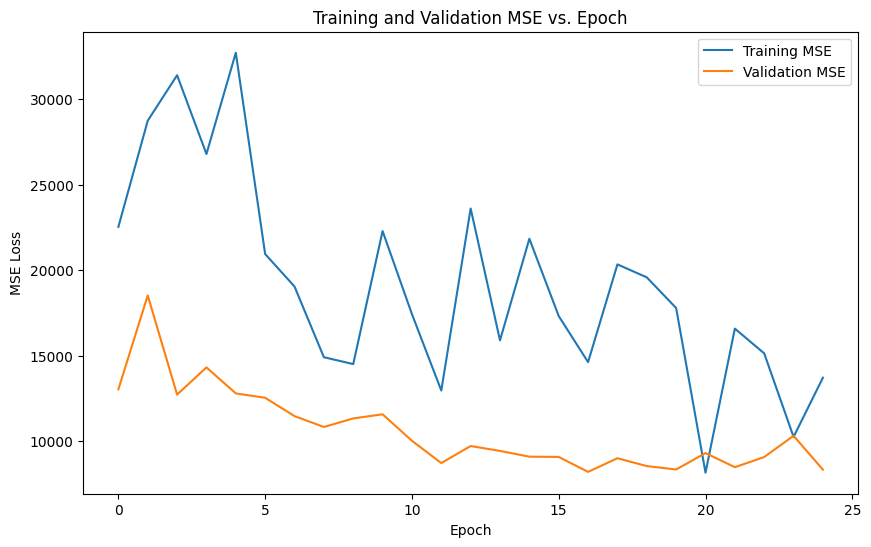

In [46]:
# Use the best hyperparameters to train the final model
best_dropout_rate = trial.params["dropout_rate"]
best_lr = trial.params["lr"]

best_model = MSFTForecastingCNN(num_features=num_features, days=days, dropout_rate=best_dropout_rate, lr=best_lr)
trainer = pl.Trainer(max_epochs=25) 
trainer.fit(best_model, datamodule=data_module)
trainer.test(best_model, datamodule=data_module)

# plot the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(loss_history.train_losses, label='Training MSE')
plt.plot(loss_history.val_losses, label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

plt.title('Training and Validation MSE vs. Epoch')
plt.legend()
plt.show()


# Step 7: Save the model
torch.save(model.state_dict(), 'msft_forecasting_cnn_optimized.pth')  
# You can load it later using:
# model.load_state_dict(torch.load('msft_forecasting_cnn.pth'))
# model.eval()  # Set the model to evaluation mode
# Note: Ensure to use the same architecture when loading the state dict.
# You can also use PyTorch Lightning's built-in save and load methods.
trainer.save_checkpoint('msft_forecasting_cnn.ckpt')     

